В этом задании вам предстоит выбрать любимый роман или книгу из предложенных по ссылкам (https://github.com/nevmenandr/word2vec-russian-novels/tree/master/books_before), либо использовать любой другой текст на ваше усмотрение, и натренировать свою модель Word2Vec на выбранном тексте. Ваша задача — продемонстрировать понимание процесса обучения модели и провести анализ результатов.

Этапы выполнения задания:

1. Выбор текста: Выберите текст для обучения модели Word2Vec. Вы можете использовать ссылки, предложенные в учебных материалах, или найти любой другой текст в формате .txt.
2. Предобработка текста: Преобразуйте выбранный текст в формат, пригодный для обучения модели. Это может включать токенизацию, удаление знаков препинания и приведение всех слов к нижнему регистру.
3. Обучение модели Word2Vec: Используйте библиотеку Gensim для создания и обучения модели Word2Vec на вашем тексте. Экспериментируйте с гиперпараметрами модели, такими как размер векторов (vector_size), ширина окна (window), минимальная частота слова (min_count) и количество потоков (workers).
4. Анализ результатов:
- Проверьте качество модели: Используйте метод most_similar для поиска аналогий и посмотрите, насколько хорошо модель захватывает семантические связи между словами.
- Визуализация векторного пространства: Используйте метод t-SNE или PCA для уменьшения размерности векторного пространства и визуализируйте его на графике. Покажите, как различные слова группируются в зависимости от их значений.

Дополнительное задание (по желанию):
- Проведите кластеризацию слов: Используйте метод K-средних или иерархическую кластеризацию для группировки слов по их векторным представлениям. Обсудите полученные результаты и их интерпретацию.

In [60]:
import requests
import nltk
import pymorphy3
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

In [61]:
# Загрузка текста и сохранение в переменную
url = 'https://raw.githubusercontent.com/nevmenandr/word2vec-russian-novels/master/books_before/MasterAndMargarita.txt'

resp = requests.get(url)
text = resp.text

print(text[1320:1526])  # Смотрим предложение, до начала предобработки текста

 В тот час, когда уж, кажется, и сил не было дышать, когда солнце, раскалив Москву, в сухом тумане валилось куда-то за Садовое кольцо, – никто не пришел под липы, никто не сел на скамейку, пуста была аллея.


In [62]:
sents = sent_tokenize(text.lower())  # Приводим весь текст к нижнему регистру, разбиваем на отдельные предложения и сохраняем в list
print(sents[10])  # Смотрим предложение до токенизации

tokenizer = RegexpTokenizer(r'\w+')  # Особенность токенайзера RegexpTokenizer - удаляет из текста все знаки препинания
sents_tokenize = [tokenizer.tokenize(sent) for sent in sents]  # Разбиваем предложения на слова
print(sents_tokenize[10])  # Смотрим предложение после токенизации

в тот час, когда уж, кажется, и сил не было дышать, когда солнце, раскалив москву, в сухом тумане валилось куда-то за садовое кольцо, – никто не пришел под липы, никто не сел на скамейку, пуста была аллея.
['в', 'тот', 'час', 'когда', 'уж', 'кажется', 'и', 'сил', 'не', 'было', 'дышать', 'когда', 'солнце', 'раскалив', 'москву', 'в', 'сухом', 'тумане', 'валилось', 'куда', 'то', 'за', 'садовое', 'кольцо', 'никто', 'не', 'пришел', 'под', 'липы', 'никто', 'не', 'сел', 'на', 'скамейку', 'пуста', 'была', 'аллея']


In [63]:
stopwords_ru = stopwords.words('russian')  # Удаляем из текста стоп-слова
sents_tokenize = [[word for word in text_cur if word not in stopwords_ru] for text_cur in sents_tokenize]
print(sents_tokenize[10])  # Смотрим предложение после очистки

['час', 'кажется', 'сил', 'дышать', 'солнце', 'раскалив', 'москву', 'сухом', 'тумане', 'валилось', 'садовое', 'кольцо', 'никто', 'пришел', 'липы', 'никто', 'сел', 'скамейку', 'пуста', 'аллея']


In [64]:
morph = pymorphy3.MorphAnalyzer()  # Приводим слова к "базовой" форме, используя pymorphy3
sents_tokenize_morph = [[morph.normal_forms(word)[0] for word in text_cur] for text_cur in sents_tokenize]
print(sents_tokenize_morph[10])  # Смотрим предложение после морфализации

['час', 'казаться', 'сила', 'дышать', 'солнце', 'раскалить', 'москва', 'сухой', 'туман', 'валиться', 'садовый', 'кольцо', 'никто', 'прийти', 'липа', 'никто', 'сесть', 'скамейка', 'пустой', 'аллея']


In [193]:
# Строим модель для обучения
model = Word2Vec(vector_size = 3, window = 2, min_count = 10, workers = 4)
# vector_size - размерность векторов, которые мы хотим обучить
# window - ширина окна контекста
# min_count - если слово встречается реже, для него не учим модель
# workers - количество потоков для обучения модели (более быстрое обучение на многоядерных машинах)

# Строительство словаря, чтобы обучение шло быстрее
model.build_vocab(sents_tokenize_morph)

# Обучение модели
model.train(sents_tokenize_morph, total_examples = model.corpus_count, epochs = 100)
# Первый аргумент - наша выборка, генератор будет вкидывать в модель наши тексты, пока они не кончатся
# Второй аргумент - число примеров в выборке
# Третий аргумент - количество эпох обучения: сколько раз модель пройдётся по всему корпусу текстов

(4311013, 7080900)

In [67]:
# Используем метод most_similar для поиска аналогий и смотрим, насколько хорошо модель захватывает семантические связи между словами
# Ниже три примера, наиболее на мой взгляд удачные из всего, что пробовал
model.wv.most_similar('туман')

[('болото', 0.6112164855003357),
 ('река', 0.5962163209915161),
 ('вливаться', 0.580112636089325),
 ('валиться', 0.5684794783592224),
 ('зажечься', 0.5609129667282104),
 ('кипеть', 0.5518164038658142),
 ('мрак', 0.5490840673446655),
 ('пузырь', 0.5484666228294373),
 ('утонуть', 0.5418177843093872),
 ('нестойкий', 0.5379297137260437)]

In [78]:
model.wv.most_similar('карман')

[('уложить', 0.6363131999969482),
 ('спрятать', 0.621029794216156),
 ('пиджак', 0.6044573783874512),
 ('вынуть', 0.5977174639701843),
 ('вытащить', 0.5806297063827515),
 ('бумажник', 0.5708292722702026),
 ('газетный', 0.5610026121139526),
 ('портфель', 0.5380142331123352),
 ('ножны', 0.5338733196258545),
 ('подушка', 0.5334852337837219)]

In [82]:
model.wv.most_similar('говорить')

[('неприятно', 0.35622262954711914),
 ('ошибаться', 0.3503168225288391),
 ('спрашивать', 0.3434985876083374),
 ('подчеркнуть', 0.34153926372528076),
 ('возразить', 0.33524733781814575),
 ('признать', 0.3328859508037567),
 ('произносить', 0.32586634159088135),
 ('доказать', 0.32076913118362427),
 ('служить', 0.32069990038871765),
 ('передёрнуть', 0.31409332156181335)]

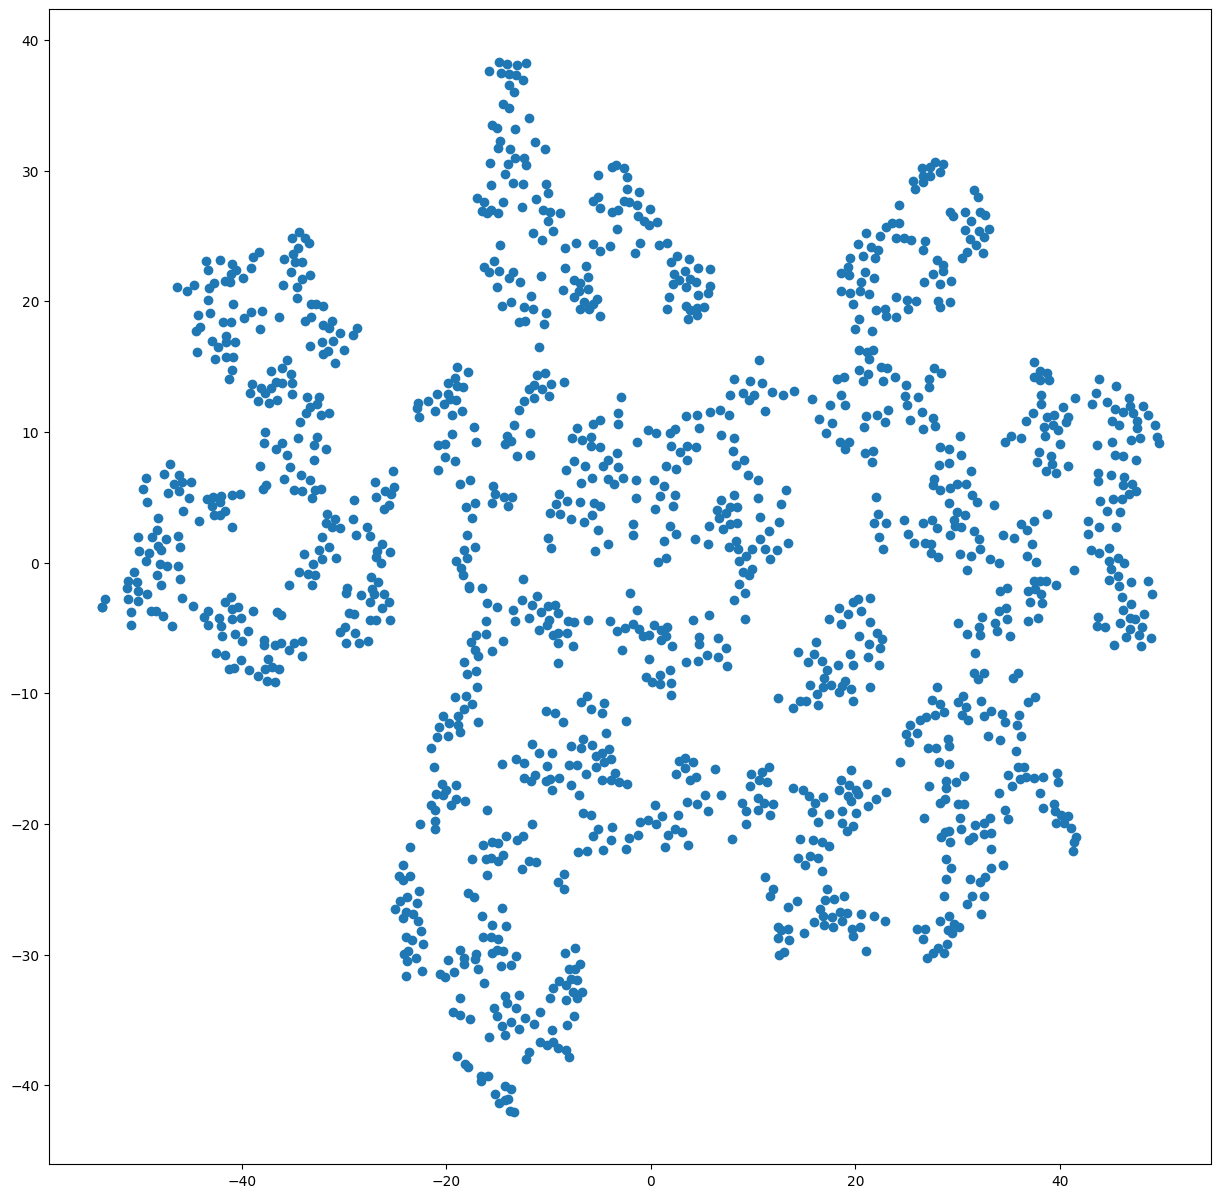

In [196]:
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
tsne = TSNE(n_components = 2, early_exaggeration = 50, n_jobs = -1)
X_tsne = tsne.fit_transform(X)

# Объединяем X_tsne и vocab в датафрейм, используя pandas
df = pd.DataFrame(X_tsne, index = vocab, columns = ['x', 'y'])

# Строим диаграмму рассеяния
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
plt.show()